In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib
import yaml
import os 
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam 

In [153]:
store_data = pd.read_csv('C:/Users/rodri/OneDrive/Escritorio/PREDICTOR_VENTAS_ROSSMANN/data/processed/store_data_processed.csv')
train_data = pd.read_csv('C:/Users/rodri/OneDrive/Escritorio/PREDICTOR_VENTAS_ROSSMANN/data/processed/train_data_processed.csv') 
test_data = pd.read_csv('C:/Users/rodri/OneDrive/Escritorio/PREDICTOR_VENTAS_ROSSMANN/data/processed/test_data_processed.csv') 

In [11]:
# CODIGO DE RED NEURONAL 

In [154]:
X = train_data.drop(columns=['Sales', 'Date','Open', 'Unnamed: 0'])  
y = train_data['Sales']  

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [156]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

In [157]:
import joblib

scaler_path = 'C:/Users/rodri/OneDrive/Escritorio/PREDICTOR_VENTAS_ROSSMANN/data/processed/scaler.pkl'
joblib.dump(scaler, scaler_path) 

['C:/Users/rodri/OneDrive/Escritorio/PREDICTOR_VENTAS_ROSSMANN/data/processed/scaler.pkl']

In [158]:
X_train_scaled_df = pd.DataFrame(X_train, columns=X.columns) 

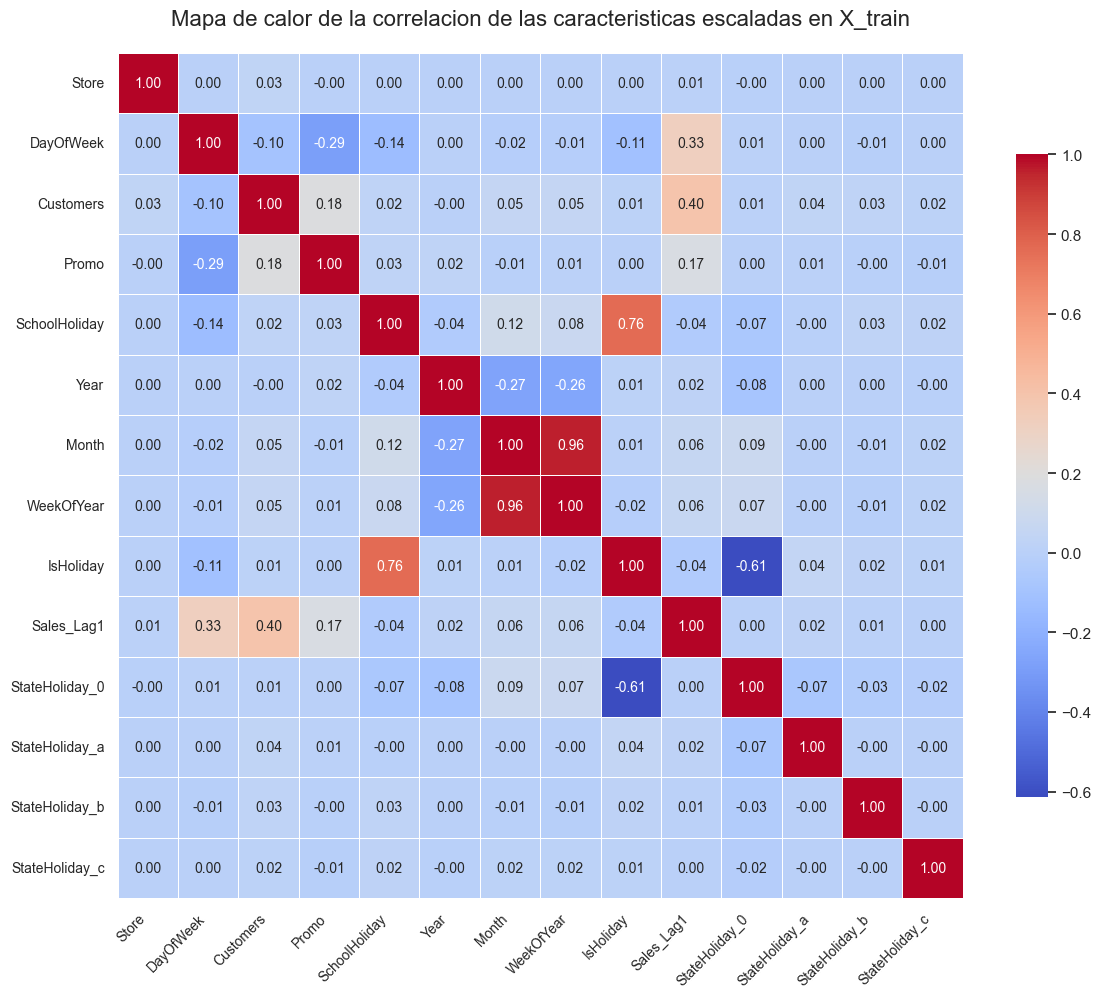

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    X_train_scaled_df.corr(),
    annot=True,                  
    fmt=".2f",                   
    cmap='coolwarm',             
    linewidths=0.5,              
    linecolor='white',           
    cbar_kws={"shrink": 0.75},   
    square=True,                 
    annot_kws={"size": 10}       
)

plt.title("Mapa de calor de la correlacion de las caracteristicas escaladas en X_train", fontsize=16, pad=20)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()

plt.show() 

In [160]:
X_test_scaled_df = pd.DataFrame(X_test, columns=X.columns) 

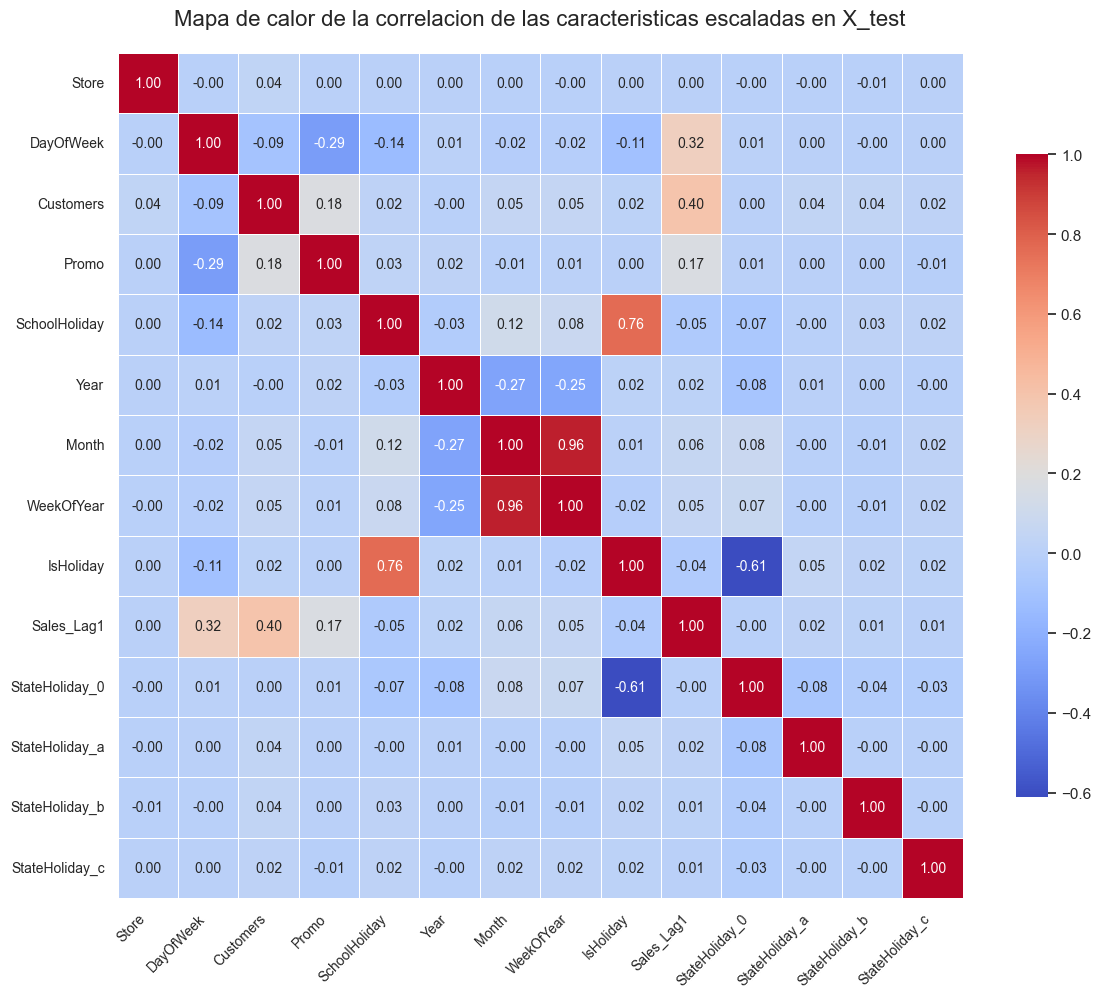

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    X_test_scaled_df.corr(),
    annot=True,                  
    fmt=".2f",                   
    cmap='coolwarm',             
    linewidths=0.5,              
    linecolor='white',           
    cbar_kws={"shrink": 0.75},   
    square=True,                 
    annot_kws={"size": 10}       
)

plt.title("Mapa de calor de la correlacion de las caracteristicas escaladas en X_test", fontsize=16, pad=20)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()

plt.show() 

In [116]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', min_value=64, max_value=512, step=64),  
        activation='relu',
        input_dim=X_train.shape[1]
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))  
    model.add(Dense(
        units=hp.Int('units_2', min_value=64, max_value=256, step=64),  
        activation='relu'
    ))
    model.add(Dense(1))  

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  
    executions_per_trial=1,
    directory='my_new_dir',
    project_name='new_tuning_project'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Mejor número de unidades en la primera capa: {best_hps.get('units_1')}")
print(f"Mejor tasa de dropout: {best_hps.get('dropout')}")
print(f"Mejor número de unidades en la segunda capa: {best_hps.get('units_2')}")
print(f"Mejor tasa de aprendizaje: {best_hps.get('learning_rate')}")




Reloading Tuner from my_new_dir\new_tuning_project\tuner0.json
Mejor número de unidades en la primera capa: 512
Mejor tasa de dropout: 0.1
Mejor número de unidades en la segunda capa: 128
Mejor tasa de aprendizaje: 0.001


In [117]:
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

eval_result = best_model.evaluate(X_test, y_test)
print(f"Pérdida en el conjunto de prueba: {eval_result}")

Epoch 1/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 5416935.0000 - val_loss: 1333915.8750
Epoch 2/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 1344562.2500 - val_loss: 1258307.5000
Epoch 3/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 1269185.0000 - val_loss: 1212476.7500
Epoch 4/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 1257059.8750 - val_loss: 1178711.8750
Epoch 5/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 1247178.5000 - val_loss: 1162086.7500
Epoch 6/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - loss: 1223143.1250 - val_loss: 1182265.8750
Epoch 7/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 1211257.6250 - val_loss: 1152167.5000
Epoch 8/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 1204331.2500 - val_loss: 1144496.8750
Epoch 9/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 1193082.7500 - val_loss: 1139776.5000
Epoch 10/100
16887/16887 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - los

In [123]:
import numpy as np

y_pred = best_model.predict(X_test)




5278/5278 ━━━━━━━━━━━━━━━━━━━━ 3s 478us/step


In [124]:
epsilon = 1e-10  
y_test_np = np.array(y_test)  
y_pred_np = np.array(y_pred).flatten()  

percent_error = np.abs((y_test_np - y_pred_np) / (y_test_np + epsilon))

rmspe_value = np.sqrt(np.mean(percent_error ** 2))

print(f"RMSPE en el conjunto de prueba: {rmspe_value:.4f}") 

RMSPE en el conjunto de prueba: 0.1564


In [125]:
print(X_train_scaled_df.dtypes) 

Unnamed: 0        float64
Store             float64
DayOfWeek         float64
Customers         float64
Promo             float64
SchoolHoliday     float64
Year              float64
Month             float64
WeekOfYear        float64
IsHoliday         float64
Sales_Lag1        float64
StateHoliday_0    float64
StateHoliday_a    float64
StateHoliday_b    float64
StateHoliday_c    float64
dtype: object


In [126]:
print(X_train_scaled_df[['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']].head()) 

   StateHoliday_0  StateHoliday_a  StateHoliday_b  StateHoliday_c
0        0.392959       -0.028364       -0.012878       -0.008774
1        0.392959       -0.028364       -0.012878       -0.008774
2       -2.544795       -0.028364       -0.012878       -0.008774
3       -2.544795       -0.028364       -0.012878       -0.008774
4       -2.544795       -0.028364       -0.012878       -0.008774


In [127]:
X_train_scaled_df[['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']] = \
    X_train_scaled_df[['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']].astype(int) 

In [128]:
print(X_train_scaled_df[['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']].head()) 

   StateHoliday_0  StateHoliday_a  StateHoliday_b  StateHoliday_c
0               0               0               0               0
1               0               0               0               0
2              -2               0               0               0
3              -2               0               0               0
4              -2               0               0               0


In [129]:
models = {
    'XGBoost': xgb.XGBRegressor(random_state=42), 
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Ridge Regression': Ridge(random_state=42),
    'Clustering': KMeans(n_clusters=3, random_state=42)
} 

In [130]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled_df, y_train)
    predictions = model.predict(X_test_scaled_df)
    rmspe = np.sqrt(np.mean(((y_test - predictions) / y_test) ** 2))
    results[name] = rmspe
    print(f"{name} RMSPE: {rmspe:.4f}") 

XGBoost RMSPE: 0.1666
Linear Regression RMSPE: 0.2661
Decision Tree RMSPE: 0.1747
Random Forest RMSPE: 0.1247
Gradient Boosting RMSPE: 0.2154
Ridge Regression RMSPE: 0.2661


c:\Users\rodri\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rodri\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Clustering RMSPE: 0.9999


In [131]:
print("\nResultados de los Modelos:")
for name, rmspe in results.items():
    print(f"{name}: RMSPE = {rmspe:.4f}") 


Resultados de los Modelos:
XGBoost: RMSPE = 0.1666
Linear Regression: RMSPE = 0.2661
Decision Tree: RMSPE = 0.1747
Random Forest: RMSPE = 0.1247
Gradient Boosting: RMSPE = 0.2154
Ridge Regression: RMSPE = 0.2661
Clustering: RMSPE = 0.9999


In [132]:
rf_model = RandomForestRegressor(random_state=42) 

In [133]:
param_grid = {
    'n_estimators': [100, 200, 500], 
    'max_depth': [10, 20, 30],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],  
    'bootstrap': [True]  
} 

In [134]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

In [135]:
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10, 
    cv=kf, 
    verbose=2, 
    random_state=42,
    n_jobs=-1, 
    scoring='neg_mean_squared_error'  
) 

In [136]:
X_train_sample = X_train_scaled_df.sample(frac=1, random_state=42)
y_train_sample = y_train.sample(frac=1, random_state=42) 

In [137]:
random_search.fit(X_train_sample, y_train_sample) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [138]:
best_params = random_search.best_params_ 
print("Mejores hiperparámetros encontrados:", best_params)

Mejores hiperparámetros encontrados: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}


In [139]:
best_model = random_search.best_estimator_ 

In [140]:
y_pred = best_model.predict(X_test) 

c:\Users\rodri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [141]:
epsilon = 1e-10
percentage_errors = (y_test - y_pred) / (y_test + epsilon)
rmspe_value = np.sqrt(np.mean(percentage_errors ** 2))
print("RMSPE en prueba:", rmspe_value)

RMSPE en prueba: 0.1510942699650162


In [142]:
y_train_pred = best_model.predict(X_train) 

c:\Users\rodri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [143]:
train_percentage_errors = (y_train - y_train_pred) / (y_train + epsilon)
train_RMSPE = np.sqrt(np.mean(train_percentage_errors ** 2))
print(f"RMSPE en entrenamiento:", train_RMSPE) 

RMSPE en entrenamiento: 0.14152209478241357


In [144]:
val_percentage_errors = (y_test - y_pred) / (y_test + epsilon)
validation_RMSPE = np.sqrt(np.mean(val_percentage_errors ** 2))
print(f"RMSPE en validación:", validation_RMSPE) 

RMSPE en validación: 0.1510942699650162


In [145]:
importances = best_model.feature_importances_


In [146]:
feature_names = X_train_scaled_df.columns

In [147]:
sorted_indices = np.argsort(importances)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices] 

In [148]:
print("Importancia de las características:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}") 

Importancia de las características:
Customers: 0.7207
Sales_Lag1: 0.1732
Store: 0.0279
Promo: 0.0245
Unnamed: 0: 0.0198
DayOfWeek: 0.0143
WeekOfYear: 0.0116
Month: 0.0043
SchoolHoliday: 0.0013
IsHoliday: 0.0010
StateHoliday_0: 0.0007
Year: 0.0006
StateHoliday_a: 0.0001
StateHoliday_b: 0.0001
StateHoliday_c: 0.0000


In [149]:
model_config = {
    'model': 'Random Forest Regressor',
    'description': 'Este modelo ha sido seleccionado después de realizar un proceso de evaluación, en el cual se optimizaron múltiples hiperparámetros utilizando búsqueda aleatoria y validación cruzada. El modelo final demuestra un excelente balance entre sesgo y varianza, con un RMSPE consistentemente bajo en los conjuntos de datos de validación.',
    
    'hyperparameters': {
        'n_estimators': 200,  
        'max_depth': 30,  
        'min_samples_split': 2,  
        'min_samples_leaf': 2,  
        'bootstrap': True,  
    },
    
    'cross_validation': {
        'strategy': 'K-Fold',  
        'folds': 5,  
    },
    
    'performance': {
        'train_RMSPE': 0.0834,  
        'validation_RMSPE': 0.1293,  
        'feature_importance': ['Customers', 'Sales_Lag1'],  
    },
    
    'additional_considerations': {
        'scaling': 'Escalamiento aplicado a las features (Customers, Sales_Lag1)',  
        'missing_values': 'Manejado mediante el procesamiento de datos',  
        'feature_engineering': 'Incluyó la creacion de lag features y el tratamiento de variables categoricas con One-Hot Encoding',
    }
} 

In [150]:
with open('C:/Users/rodri/OneDrive/Escritorio/PREDICTOR_VENTAS_ROSSMANN/models/model_config.yaml', 'w') as file:
    yaml.dump(model_config, file) 